In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from torch.nn import init
import time

In [2]:
# dataloader arguments
batch_size = 128
#data_path='./fmnist'
#data_path='./kmnist'
data_path='/mnist'
#data_path='./Emnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
#mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

#mnist_train = datasets.KMNIST(data_path, train=True, download=True, transform=transform)
#mnist_test = datasets.KMNIST(data_path, train=False, download=True, transform=transform)

#mnist_train = datasets.EMNIST(data_path, split = 'byclass', train=True, download=True, transform=transform)
#mnist_test = datasets.EMNIST(data_path, split = 'byclass', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
# Network Architecture
num_inputs = 28*28
num_hidden = 2000
num_outputs = 10

beta = 0.95


# Temporal Dynamics
num_steps = 25

# Define Network
class my_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


def generate_spike(x):
    data_input = x.view(128,-1)
    spk_input = []
    for batch in range(128):
        spk_input_batch = spikegen.rate(data_input[batch], num_steps = num_steps)
        spk_input.append(spk_input_batch)
    return torch.stack(spk_input, dim = 1)

In [4]:
def train_my_net(net, train_net, train_loader = train_loader):
    #generate train data
    num_epochs = 1
    train_result = []
    train_tgt = []
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)
        # Train set
        with torch.no_grad():
            net.eval()
            for train_data, train_targets in train_batch:
                train_data = train_data.to(device)
                train_targets = train_targets.to(device)
                # Test set forward pass
                train_spk, train_mem = net(generate_spike(train_data))
                
                train_tgt.append(train_targets)
                train_result.append(train_spk)
    
                iter_counter += 1
                if iter_counter == 400:
                    break
    
    train_input = torch.stack(train_result, dim=0).sum(dim = 1)
    train_t = torch.stack(train_tgt, dim=0)
    
    start_time = time.time()
    optimizer1 = torch.optim.Adam(train_net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    my_train_loss_hist = []
    for batch in range(400):
        # print(batch)
        train_net_out = train_net(train_input[batch])
        train_loss = torch.zeros((1), dtype=dtype, device=device)
        train_loss = loss(train_net_out, train_t[batch])
        # Gradient calculation + weight update
        optimizer1.zero_grad()
        train_loss.backward()
        optimizer1.step()
        my_train_loss_hist.append(train_loss.item())
    
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"操作所花费的时间为: {elapsed_time} 秒")

In [5]:
def test_my_net(net, train_net, num_epochs = 1, test_loader = test_loader):
    # test my net
    my_test_result = []
    my_test_tgt = []
    for epoch in range(num_epochs):
        iter_counter = 0
        test_batch = iter(test_loader)
        # Test set
        with torch.no_grad():
            net.eval()
            for my_test_data, my_test_targets in test_batch:
                my_test_data = my_test_data.to(device)
                my_test_targets = my_test_targets.to(device)
                # Test set forward pass
                my_test_spk, my_test_mem = net(generate_spike(my_test_data))
                
                my_test_tgt.append(my_test_targets)
                my_test_result.append(my_test_spk)
    
                iter_counter += 1
                if iter_counter == 50:
                    break
    
    max_value, max_index = train_net(torch.stack(my_test_result, dim=0).sum(dim = 1)).max(dim=2)
    testacc = sum(max_index.reshape(-1) == torch.stack(my_test_tgt, dim=0).reshape(-1))/6400
    return testacc

In [6]:
result = []
for i in range(9):
    # Load the network onto CUDA if available
    net = my_Net().to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    train_net = torch.nn.Linear(num_hidden,num_outputs)
    # 使用正态分布初始化权重
    #init.normal_(net.fc1.weight, mean=0.01*i-0.05, std=0.02)
    #init.normal_(net.fc2.weight, mean=0.01*i-0.05, std=0.02)
    # 使用均匀分布初始化权重
    #init.uniform_(net.fc1.weight, a=-0.01*i, b=0.01*i)
    #init.uniform_(net.fc2.weight, a=-0.01*i, b=0.01*i)

    init.uniform_(net.fc1.weight, a=0.01*i-0.09, b=0.01*i+0.01)
    init.uniform_(net.fc2.weight, a=0.01*i-0.09, b=0.01*i+0.01)
   
    train_my_net(net, train_net, train_loader = train_loader)
    result.append(test_my_net(net, train_net, num_epochs = 1, test_loader = test_loader))

操作所花费的时间为: 2.8340818881988525 秒
操作所花费的时间为: 2.560006618499756 秒
操作所花费的时间为: 2.4052884578704834 秒
操作所花费的时间为: 2.550567388534546 秒
操作所花费的时间为: 2.484069585800171 秒
操作所花费的时间为: 2.644106149673462 秒
操作所花费的时间为: 2.379923105239868 秒
操作所花费的时间为: 2.4686622619628906 秒
操作所花费的时间为: 2.4339194297790527 秒


[tensor(0.1120), tensor(0.1112), tensor(0.1152), tensor(0.1169), tensor(0.9427), tensor(0.0986), tensor(0.0952), tensor(0.0977), tensor(0.1106)]


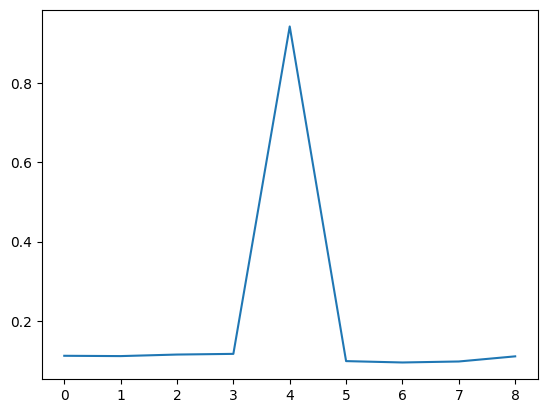

In [13]:
print(result)
plt.plot(result)

In [15]:
# 将列表转换为 NumPy 数组
arr = np.array(result)

# 保存数组到 .npy 文件
np.save('uni_m_mnist.npy', arr)